## procgen-tools

Code for a series of experiments and associated tools for interpreting agents trained on _procgen_, specifically the `maze` environment as used in [Goal Misgeneralization in Deep Reinforcement Learning](https://arxiv.org/abs/2105.14111) by Longosco et al.

This repository was initially created by the shard theory team during the SERI MATS 3.0 research fellowship program.

**Disclaimer:** *this repository is a work-in-progress research codebase built to produce results quickly. It lacks tests and proper documentation, and will likely undergo interface-breaking refectorings several times as this research continues. We hope it's a helpful resource nonetheless! If this code is useful or you'd like to contribute to this work, we'd love to hear from you!*

The repository is organized as follows:
- `experiments` contains research materials considered interesting or significant enough to (eventually) be documented and shared.
- `playground` contains early-stage or work-in-progress research, or archival materials for discontinued research threads.
- `procgen_tools` is a Python package containing the shared tooling used by the above research.  It can be installed from local source using `pip install -e procgen-tools`

Required dependencies should be installed using `pip install -r requirements.txt`.  

Data dependencies (cached episode data, etc.) will be downloaded automatically when needed.

### Code Associated with Publications

TODO: refer to specific files associated with the LessWrong post (and others in the future)


### Key Features

#### Maze State Parsing, Editing and Updating

Code for parsing, editing and updateing maze state can be found in [procgen/maze.py].  A few usage examples are below.

Create an environment, parse the state and show all the accessible state variables, and show a rendering of the initial frame:

dict_keys(['SERIALIZE_VERSION', 'game_name', 'options.paint_vel_info', 'options.use_generated_assets', 'options.use_monochrome_assets', 'options.restrict_themes', 'options.use_backgrounds', 'options.center_agent', 'options.debug_mode', 'options.distribution_mode', 'options.use_sequential_levels', 'options.use_easy_jump', 'options.plain_assets', 'options.physics_mode', 'grid_step', 'level_seed_low', 'level_seed_high', 'game_type', 'game_n', 'level_seed_rand_gen.is_seeded', 'level_seed_rand_gen.str', 'rand_gen.is_seeded', 'rand_gen.str', 'step_data.reward', 'step_data.done', 'step_data.level_complete', 'action', 'timeout', 'current_level_seed', 'prev_level_seed', 'episodes_remaining', 'episode_done', 'last_reward_timer', 'last_reward', 'default_action', 'fixed_asset_seed', 'cur_time', 'is_waiting_for_step', 'grid_size', 'ents.size', 'ents', 'use_procgen_background', 'background_index', 'bg_tile_ratio', 'bg_pct_x', 'char_dim', 'last_move_action', 'move_action', 'special_action', 'mixrate'

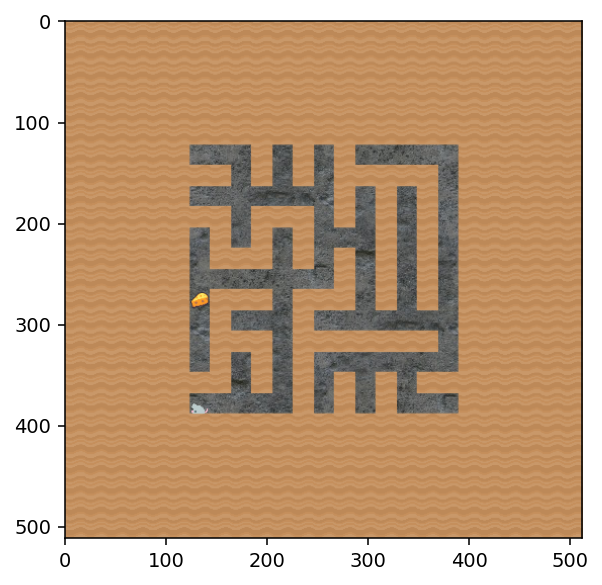

In [12]:
import matplotlib.pyplot as plt
from procgen_tools import maze
# Create a maze environment
venv = maze.create_venv(1, start_level=0, num_levels=1)
# Parse the environment state
env_state = maze.state_from_venv(venv, 0)
# Display state values
print(env_state.state_vals.keys())
# Show a rendering of the first
venv.reset()
render = venv.render(mode='rgb_array')
plt.imshow(render)
plt.show()

Then, modify the cheese position, update the environment, and render again:

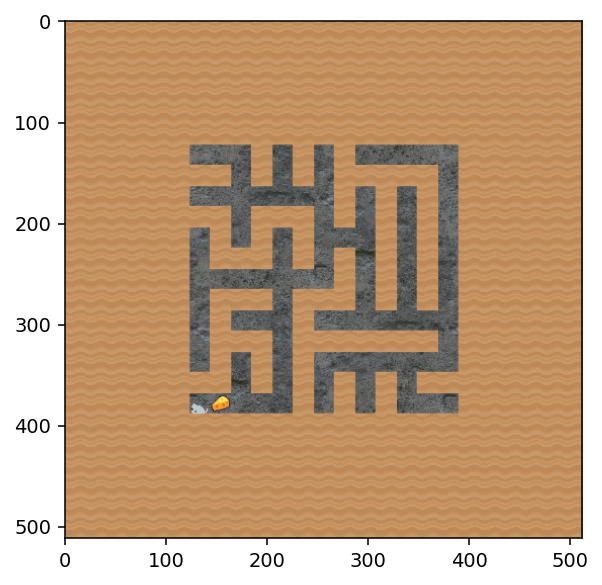

In [13]:
maze.move_cheese_in_state(env_state, (6,7))
venv.env.callmethod('set_state', [env_state.state_bytes])
venv.reset()
render = venv.render(mode='rgb_array')
plt.imshow(render)
plt.show()

#### Interpretable, Parameter-Compatible Implementations of IMPALA Models

We use the `circrl` library to automatically apply forward hooks to pre-trained models, provide access to internal activations at all hidden layers, and apply patches and ablations of various kinds.  This library uses the pytorch `named_modules()` function to label and hook hidden layers.  The pretrained IMPALA models from the Goal Misgeneralization paper were implemented in such a way that certain important parameter-free modules (e.g. `ReLU()`s) were newly created at each forward call, making it difficult to apply hooks to extract the activations of these layers.  We implemented modified versions of these [models](procgen_tools/models.py) that create and name all modules during construction to facilitate later interpretability work.  The resulting model classes are parameter-compatible with the original pretrained models so `state_dict`s can be loaded unchanged.

#### Vector Field Visualizations

A key visualization that is used extensively in this research is the "vector field", a tool to show the agent's action probabilities when positioned at each free square in the maze, simultaneously.  We find this visualization superior to rollout-viewing in most cases as it removes stochasticity and visualizes agent behavior across a full maze in a single frame.  Vector fields can be show like so:

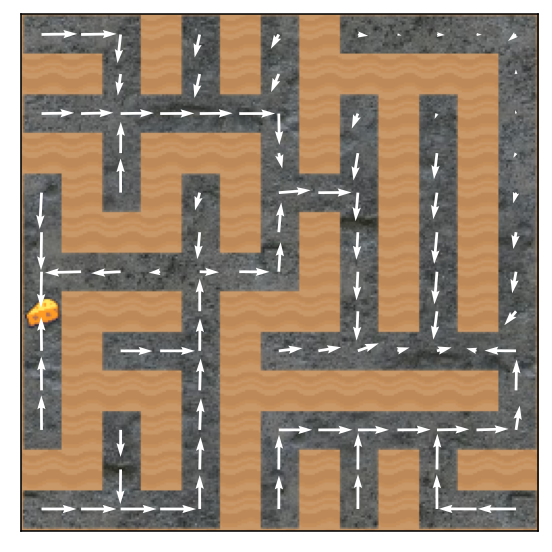

In [15]:
import torch as t
from procgen_tools import maze, vfield, models

# Load pretrained policy
policy = models.load_policy('trained_models/maze_I/model_rand_region_5.pth', 15, t.device('cpu'))
venv = maze.create_venv(1, start_level=0, num_levels=1)
vf_original = vfield.vector_field(venv, policy)
vfield.plot_vf(vf_original)
plt.show()

From this visualization we can clearly see that at the "decision square" (the square at which the paths to the cheese and the top-right corner diverge, an important square when studying these goal-misgeneralizating agents), this agent will choose with fairly high probability to go towards the top-right corner.

Support is also provided for "vector field diff" visualizations, a tool for visualizing the effect of some kind of model intervention (patch, etc) on behavior within a given maze.  As an example, we'll add some random noise to a hidden layer in the model, and observe the effect on action probabilities:

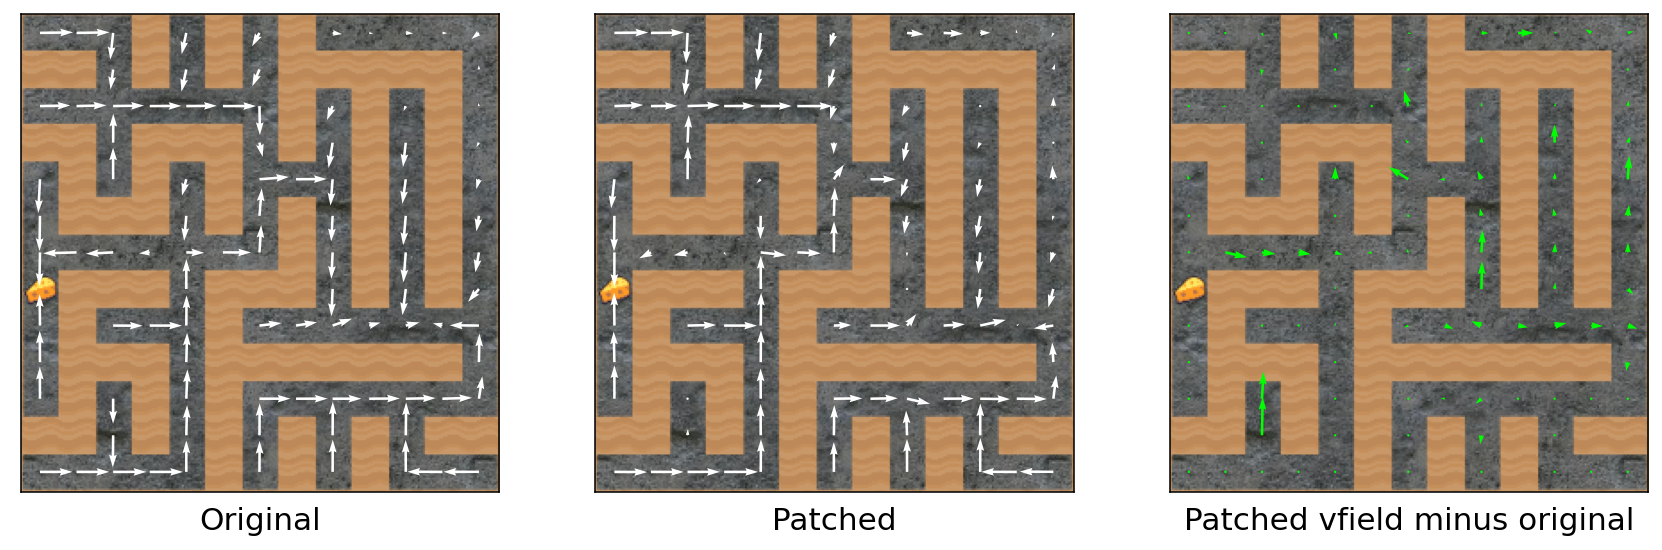

In [19]:
import circrl.module_hook as cmh
hook = cmh.ModuleHook(policy)
patches = {'embedder.block2.res1.resadd_out': lambda outp: outp + 0.2*t.randn_like(outp)}
venv = maze.create_venv(1, start_level=0, num_levels=1)
with hook.use_patches(patches):
    vf_patched = vfield.vector_field(venv, hook.network)
vfield.plot_vfs(vf_original, vf_patched)
plt.show()


#### Misc
- [Procgen wrappers](procgen_tools/procgen_wrappers.py) similifies environment-related dependencies
- [Patching utilities](procgen_tools/patch_utils.py) provides various patching-related utility functions
- [Rollout utilities](procgen_tools/rollout_utils.py) provides code to e.g. render side-by-side rollout videos